# Vektorius
The Vektorius API allows you to work with tabular data to perform complex analysis remotely and view the results locally. It uses a fluent DSL for executing remote queries with a Pandas-like interface so that working with remote and local data feels the same. One of the big benefits of Vektorius is support for Geospatial operations both remotely, and locally!

## Data
You can work with a few different tables:
- `ports_v2`
- `vessels_v3`
- `voyages_v1b_voyage`
- `voyages_v1b_route`

You'll see a few different ways to use data in these tables as you work through these tutorials, but you can do a lot more than is laid out here!


# Client
The `vector` client provides access to the Vektorius API.

In [ ]:
from descarteslabs.vektorius import vector

# DatabaseTable
To start working with data you need to get a `DatabaseTable`.

###### NOTE
If you want to see the pretty SVG images, you'll need to `pip install graphviz` into your environment, otherwise you'll only see `str` representations of expressions.

In [ ]:
ports = vector.table("ports_v2")
ports

When you first get a `DatabaseTable` you don't actually fetch any data, instead you create an `Expression`. For the most part, you can think of an `Expression` as a database query. `DatabaseTable` is one of many different types of `Expression`s and it contains some _super_ helpful information about the schema that the data conforms to (and if you're familiar with SQL, a `DatabaseTable` is like the super simple `SELECT * FROM mytable;`).

So, if an `Expression` is just a query, how do we run it and interact with the results? To do that, we need to `execute` our `Expression`. `execute` tells our remote data source to run our `Expression` and return a GeoPandas `GeoDataFrame` containing the results.  A key idea to remember is: before you `execute` you're working with `Expression`s, and after you've got a `GeoDataFrame`.

In [ ]:
df = ports.limit(10).execute()
df

## Column Selection
Sometimes it useful to fetch all the columns from a table, but most of the time, you'll only need a few columns. In general it's best to _only_ fetch data from the columns that you need.  You can pick which columns you want in your `DataFrame` by creating a new type of `Expression` called a `Selection`.  Our `Selection` is related to the original `DatabaseTable`, but only contains a subset of it's columns.

In [ ]:
ports_info = ports[ports.port_name, ports.port_geom]
ports_info

When you `execute` the `Selection`, you get a very different `GeoDataFrame` back:

In [ ]:
df = ports_info.limit(10).execute()
df

`Column Selection` is an important part of writing clear, performant queries, remember to return _only_ the columns you care about!

# Filtering
Just list with columns, you usually don't care about _all_ the rows in a `DatabaseTable`.  You probably want to `Filter` out rows that aren't important for your analysis. To do this, you can use the aptly named `filter` method to create a `Selection` that `Filters` rows.  The Python comparison operators (`==`, `!=`, `>`, `>=`, `<`, `<=`) all work for constructing `Filters`.

In [ ]:
china_ports = ports.filter(ports.region_name == "CHINA")
china_ports

You can combine `Column Selection` and `Filtering` to return _exactly_ what you need.

In [ ]:
china_ports_projection = china_ports[china_ports.port_name, china_ports.harbor_size, china_ports.port_geom]
df = china_ports_projection.execute()
df

`Filters` can be combined in some pretty complex ways, so it's often useful to construct your `Filter` _before_ applying it, to make things a little more readble. You can use bitwise `&` and `|` to combine expressions, and `()` groupings to enforce precendence.

 Say you're interested in finding Ports in China with `Excellent` or `Good` shelter _OR_ Ports in China of any shelter but with a low tide range. You can construct the `Filter` `Expressions` before applying the `Filter` to make nice clean statements

In [ ]:
well_sheltered = (china_ports.shelter_afforded == "E") | (china_ports.shelter_afforded == "G")
low_tide_range = china_ports.tide_range < 3
interesting_ports_filter = well_sheltered | low_tide_range

my_ports = china_ports.filter(interesting_ports_filter)
my_ports = my_ports[my_ports.port_name, my_ports.port_geom, my_ports.shelter_afforded, my_ports.tide_range]
df = my_ports.execute()
df

Column `Expressions` also provide some special methods for doing certian types of predicates for `Filters`

##### List-value checking
You can test whether a value is or is not contained in a list to avoid complex chained `|` expressions:


`ports.shelter_afforded.isin(["E", "G"])` 

or 

`ports.shelter_afforded.notin(["F", "P"])`

##### Range checking
You can test for ranges of value with between:

`ports.tide_range.between(0, 2)`

##### Null testing
Always use `isnull`/`notnull` to test for `NULL` values.  **DO NOT USE** `table.column_name is None` to do this kind of test, you'll get incorrect results

`ports.port_geom.isnull()` 

or 

`ports.port_geom.notnull()`

# GeoSpatial Filtering
You can also `Filter` rows using GeoSpatial operations.  So, to find ports in an area of the South China Sea:

In [ ]:
from shapely.geometry import shape

aoi_geojson = {
    "type": "Polygon",
    "coordinates": [
        [
            [104.9853515625, 11.049038346537106],
            [124.1455078125, 11.049038346537106],
            [124.1455078125, 24.766784522874453],
            [104.9853515625, 24.766784522874453],
            [104.9853515625,11.049038346537106]
        ]
    ]
}
aoi = shape(aoi_geojson)
ports_filter = ports.port_geom.intersects(aoi)
my_ports = ports.filter(ports_filter)
my_ports = my_ports[my_ports.port_name, my_ports.port_geom]
my_ports = my_ports.execute()
my_ports

`IPyLeaflet` gives you helpers to visualize your `GeoDataFrame`:

In [ ]:
from ipyleaflet import Map, GeoData, GeoJSON

# create your map
m = Map(center=(17.853290114098012, 116.96044921875), zoom=5)

# create and configure the data layer
geo_json = GeoData(
    geo_dataframe=my_ports,
    style=dict(opacity=1,
               color="black",
               fillOpacity=0.75,
               weight=2,
               fillColor="orange"),
    hover_style=dict(color="white",
                     fillOpacity=0.5)
)
aoi = GeoJSON(
    data=aoi_geojson,
    style=dict(opacity=1,
               color="black",
               fillOpacity=0.5,
               weight=2,
               fillColor="blue"),
    hover_style=dict(color="white",
                     fillOpacity=0.5))
m.add_layer(aoi)
m.add_layer(geo_json)
m

### An aside, into the weeds
Vektorius represents all GeoSpatial data in EPSG:4326 with geodesic edges between points. Because of this, `Geometries` that use planar edges (like GeoJSON) require special handling in `Filters`. When interpreting a GeoJSON `Geometry`, more points are added along edges to make to preserve the planar shape of the edge in a geodesic representation. This introduces a small amount of error, since you can't perfectly represent the planar shape with curved lines.  However, this error is much smaller than interpreting the original planar edge as a geodesic edge:

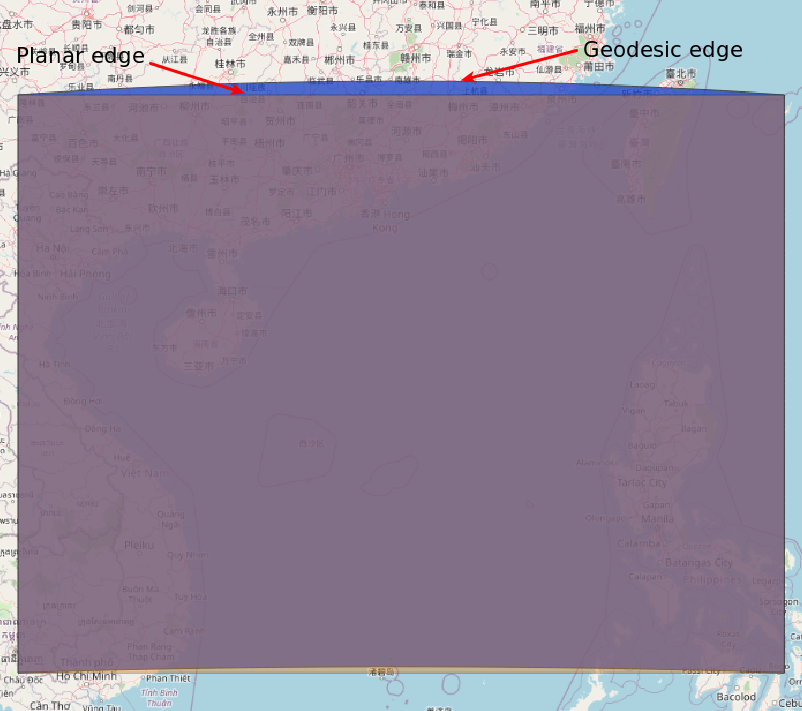

Because GeoJSON is so ubiquitous as a means for constructing Shapely `Geometries` we assume that you provided a shape with planar edges by default.  However, if you have a shape that should be interpreted wit geodecis edges, you can set the `crs` property of the `Geometry` to `EPSG:4326`. When you do this, the `Geometry` isn't altered at all, which leads to slightly different results from a query using the same shape but with planar edges.

In [ ]:
aoi = shape(aoi_geojson)
aoi.crs = "EPSG:4326"
orig_ports = my_ports
ports_filter = ports.port_geom.intersects(aoi)
my_ports = ports.filter(ports_filter)
my_ports = my_ports[my_ports.port_name, my_ports.port_geom]
my_ports = my_ports.execute()
my_ports